# Bayesian seats model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Build-a-Stan-model-and-fit-the-data-to-the-model" data-toc-modified-id="Build-a-Stan-model-and-fit-the-data-to-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build a Stan model and fit the data to the model</a></span></li><li><span><a href="#Diagnostics" data-toc-modified-id="Diagnostics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Diagnostics</a></span></li><li><span><a href="#Visualise-results" data-toc-modified-id="Visualise-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualise results</a></span><ul class="toc-item"><li><span><a href="#Seats-won" data-toc-modified-id="Seats-won-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Seats won</a></span></li><li><span><a href="#House-outcome" data-toc-modified-id="House-outcome-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>House outcome</a></span></li></ul></li><li><span><a href="#Relationship-between-2pp-vote-share-majority-party-seat-share" data-toc-modified-id="Relationship-between-2pp-vote-share-majority-party-seat-share-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Relationship between 2pp vote share majority party seat share</a></span></li><li><span><a href="#Model-for-non-major-party-members" data-toc-modified-id="Model-for-non-major-party-members-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model for non-major party members</a></span></li></ul></div>

## Python setup

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import arviz as az
import stan # install with pip - conda is problematic on the M1 MBP
print(f'Stan version: {stan.__version__}')
print(f'ArviZ version: {az.__version__}')

# system imports
import pathlib

Stan version: 3.3.0
ArviZ version: 0.11.4


In [2]:
# enable pystan on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [3]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

CHART_DIR = '../charts'
pathlib.Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
CHART_DIR += '/'

In [4]:
# data locations
SEAT_HISTORY_FILE = '../data/Seat History.csv'

## Get the data

Note: the data was produced by the "capture wiki election history data and preliminary charts" notebook.

In [5]:
def fix_column_names(t: pd.DataFrame) -> pd.DataFrame:
    """Replace 'Unnamed' column names with ''."""
    
    replacements = {}
    for c in t.columns:
        if 'Unnamed' in c[1]:
            replacements[c[1]] = ''
    if replacements:
        t = t.rename(columns=replacements, level=1)
    return t

In [6]:
# Load historical elections data
seat_history = pd.read_csv(SEAT_HISTORY_FILE, header=[0, 1], 
                           index_col=0, parse_dates=[0], )
seat_history = fix_column_names(seat_history)
seat_history.index.dtype

dtype('<M8[ns]')

In [7]:
seat_history.columns

MultiIndex([(               'Primary vote',   'ALP'),
            (               'Primary vote',  'L+NP'),
            (               'Primary vote',  'Oth.'),
            (                   '2PP vote',   'ALP'),
            (                   '2PP vote',  'L+NP'),
            (                      'Seats',   'ALP'),
            (                      'Seats',  'L+NP'),
            (                      'Seats',  'Oth.'),
            (                      'Seats', 'Total'),
            ('Governing party at election',      ''),
            (            'Governing since',      ''),
            (             'PM at election',      ''),
            (              'Winning party',      ''),
            (                      'Notes',      ''),
            (             'log gov period',      ''),
            (                     'winner',      ''),
            (      'Govt 2pp votes margin',      ''),
            (          'Govt seats margin',      '')],
           )

In [8]:
seat_history['Proportion of others'] = (
    seat_history[('Seats',  'Oth.')] 
    / seat_history[('Seats', 'Total')]
)

In [9]:
# limit input data to recent history
HISTORY_START = 1969 # let's start with Don's party ...
seat_history = seat_history[seat_history.index.year >= HISTORY_START]
seat_history

Primary vote               2PP vote        Seats                    \
                    ALP   L+NP   Oth.      ALP   L+NP   ALP  L+NP Oth.  Total   
Date                                                                            
1969-10-25        0.470  0.433  0.097    0.502  0.498  59.0  66.0  0.0  125.0   
1972-12-02        0.496  0.415  0.089    0.527  0.473  67.0  58.0  0.0  125.0   
1974-05-18        0.493  0.449  0.058    0.517  0.483  66.0  61.0  0.0  127.0   
1975-12-13        0.428  0.531  0.041    0.443  0.557  36.0  91.0  0.0  127.0   
1977-12-10        0.397  0.481  0.122    0.454  0.546  38.0  86.0  0.0  124.0   
1980-10-18        0.452  0.463  0.085    0.496  0.504  51.0  74.0  0.0  125.0   
1983-03-05        0.495  0.436  0.069    0.532  0.468  75.0  50.0  0.0  125.0   
1984-12-01        0.476  0.450  0.074    0.518  0.482  82.0  66.0  0.0  148.0   
1987-07-11        0.458  0.461  0.081    0.508  0.492  86.0  62.0  0.0  148.0   
1990-03-24        0.394  0.435  0.171    0.499  0.501  78.0  69.0  1.0  148.0   
1993-03-13        0.449  0.443  0.107    0.514  0.486  80.0  65.0  2.0  147.0   
1996-03-02        0.387  0.473  0.140    0.464  0.536  49.0  94.0  5.0  148.0   
1998-10-03        0.401  0.395  0.204    0.510  0.490  67.0  80.0  1.0  148.0   
2001-11-10        0.378  0.430  0.192    0.490  0.510  65.0  82.0  3.0  150.0   
2004-10-09        0.376  0.467  0.157    0.473  0.527  60.0  87.0  3.0  150.0   
2007-11-24        0.434  0.421  0.145    0.527  0.473  83.0  65.0  2.0  150.0   
2010-08-21        0.380  0.433  0.187    0.501  0.499  72.0  72.0  6.0  150.0   
2013-09-07        0.334  0.456  0.210    0.465  0.535  55.0  90.0  5.0  150.0   
2016-07-02        0.347  0.420  0.233    0.496  0.504  69.0  76.0  5.0  150.0   
2019-05-18        0.333  0.414  0.253    0.485  0.515  68.0  77.0  6.0  151.0   

           Governing party at election Governing since PM at election  \
                                                                        
Date                                                                    
1969-10-25                        L+NP      1949-12-19         Gorton   
1972-12-02                        L+NP      1949-12-19        McMahon   
1974-05-18                         ALP      1972-12-05        Whitlam   
1975-12-13                        L+NP      1975-11-11         Fraser   
1977-12-10                        L+NP      1975-11-11         Fraser   
1980-10-18                        L+NP      1975-11-11         Fraser   
1983-03-05                        L+NP      1975-11-11         Fraser   
1984-12-01                         ALP      1983-03-11          Hawke   
1987-07-11                         ALP      1983-03-11          Hawke   
1990-03-24                         ALP      1983-03-11          Hawke   
1993-03-13                         ALP      1983-03-11        Keating   
1996-03-02                         ALP      1983-03-11        Keating   
1998-10-03                        L+NP      1996-03-11         Howard   
2001-11-10                        L+NP      1996-03-11         Howard   
2004-10-09                        L+NP      1996-03-11         Howard   
2007-11-24                        L+NP      1996-03-11         Howard   
2010-08-21                         ALP      2007-12-03        Gillard   
2013-09-07                         ALP      2007-12-03           Rudd   
2016-07-02                        L+NP      2013-09-18       Turnbull   
2019-05-18                        L+NP      2013-09-18       Morrison   

           Winning party                                              Notes  \
                                                                              
Date                                                                          
1969-10-25          L+NP                                                NaN   
1972-12-02           ALP                                                NaN   
1974-05-18           ALP                                                

In [10]:
# limit autoregressive model of non-major party members to an even more recent period
seat_history['Row number'] = range(1, len(seat_history)+1)
AUTOREGRESS_FROM = 1993 # previous election non-zero, also subsequent also non-zero
assert(AUTOREGRESS_FROM >= HISTORY_START)
ar_from = seat_history.loc[seat_history.index.year == AUTOREGRESS_FROM, 'Row number'].values[0]
ar_from

11

In [11]:
len(seat_history)

20

## Build a Stan model and fit the data to the model

In [12]:
SEATS_NEXT_PARLIAMENT = 151
WIN_THRESHOLD = 75.5 # which will round up to 76 ...
seats_data = {

    'n_seats': SEATS_NEXT_PARLIAMENT,
    'win_threshold': WIN_THRESHOLD,
    'tpp': 0.47, # Still to code a polling model

    'n_history': len(seat_history),
    'seats': seat_history['Govt seats margin'].values,
    'votes': seat_history['Govt 2pp votes margin'].values,
    
    'others': seat_history['Proportion of others'].values,
    'ar_from': ar_from,
}

In [13]:
seats_model = """
data {
    real<lower=0,upper=1> tpp; // STILL TO CODE: from polls to tpp
    
    int<lower=1> n_seats;     // number of seats in parliament next election
    real<lower=0,upper=n_seats> win_threshold; // account for rounding to ints
    
    int<lower=1> n_history;    // length of election history
    vector<lower=-1,upper=1>[n_history] seats;  // Coalition seats margin (response)
    vector<lower=-1,upper=1>[n_history] votes;  // Coalition votes margin (inputs)

    vector<lower=0,upper=1>[n_history] others;
    int<lower=1> ar_from;

    // constraint management
}

transformed data {
    real almost_zero = 0.00001;
}

parameters {

    // historical relationship between 2pp votes and seats
    real slope;
    real intercept;
    real<lower=almost_zero> sigma; // force half cauchy with lower bound
    
    // historical relationship for other parties in house
    // auto regressive, this year is much like last year
    real drift;
    real replication;
    real<lower=almost_zero> s; // force half cauchy with lower bound
    
    // TO DO - model historic polling accuracy for predicting 2pp vote share
}


model {
    // priors on vote difference
    intercept ~ normal(0, 1);
    slope ~ normal(3, 1);      
    sigma ~ cauchy(0, 10);

    // priors on auto-regressive non-major-party seat proportion
    drift ~ normal(0.0, 0.1);     // prior
    replication ~ normal(1, 0.1); // prior
    s ~ cauchy(0, 10);

    // linear regression from 2pp vote difference to seats difference
    // use student_t here for the fatter tails ...
    seats ~ student_t(5, intercept + (slope * votes), sigma); // fatter tails
    //seats ~ normal(intercept + (slope * votes), sigma); // normal dist.
    
    // limited autoregressive(1) model over recent data
    // for proportion of non-major-party seats
    others[ar_from:n_history] ~  
        normal(drift + (replication * others[(ar_from-1):(n_history-1)]), s);
    
    // TO DO - model historic polling accuracy for predicting 2pp vote share
}

generated quantities {

    // --- MODEL DIAGNOSTICS ---
    
    // 2pp to seats relationship
    vector<lower=-1,upper=1>[n_history] seats_estimate;
    seats_estimate = slope * votes + intercept;
    
    // prediction interval on 2pp to seats relationship
    real<lower=-1,upper=1> predict_interval[n_history] = 
        normal_rng(intercept + (slope * votes), sigma);
    
    
    // --- 2022 FORECAST ---

    // seats won by other parties
    real<lower=0,upper=n_seats> other_seats = 
        (drift + (replication * others[n_history])) * n_seats;

    // seats remaining available for the Coalition and Labor
    real<lower=0,upper=n_seats> available_seats = n_seats - other_seats;

    // Given the Coalition's TPP, how many seats will the Coalition/Govt win?
    // Note: regression based on student_t, but prediction is from normal.
    real seats_forecast = normal_rng(slope * (tpp - (1 - tpp)) + intercept, sigma);
    
    real<lower=0,upper=n_seats> government_seats = 
        (available_seats / 2)
        + (seats_forecast * (available_seats / 2));

    // Labor seats = total seats - other seats - Coalition seats
    real<lower=0,upper=n_seats> opposition_seats = 
        (available_seats - government_seats);

    // How often does the Coalition government win the election?
    int<lower=0,upper=1> government_wins = government_seats > win_threshold ? 1 : 0;

    // How often does the Labor opposition win?
    int<lower=0,upper=1> opposition_wins = opposition_seats > win_threshold ? 1 : 0;
    
    // How often do we get a hung parliament?
    int<lower=0,upper=1> hung_parliament = 
        (government_wins == 0 && opposition_wins == 0) ? 1 : 0;
}
"""

In [14]:
posterior = stan.build(seats_model, data=seats_data)

Building: found in cache, done.


In [15]:
fit = posterior.sample(num_chains=4, num_samples=25_000)

Sampling:   0%
Sampling:  25% (26000/104000)
Sampling:  50% (52000/104000)
Sampling:  75% (78000/104000)
Sampling: 100% (104000/104000)
Sampling: 100% (104000/104000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in '/var/folders/yp/w0p94kjs6n38mrs_sjkm51pc0000gn/T/httpstan_0l0kkee1/model_hqeo3bse.stan', line 52

## Diagnostics

In [16]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,3.352,0.312,2.741,3.919,0.001,0.001,118072.0,68655.0,1.0
intercept,0.036,0.017,0.005,0.069,0.000,0.000,117128.0,70385.0,1.0
sigma,0.065,0.014,0.041,0.091,0.000,0.000,109739.0,72451.0,1.0
drift,0.004,0.006,-0.008,0.016,0.000,0.000,99178.0,69072.0,1.0
replication,0.960,0.099,0.772,1.145,0.000,0.000,114041.0,77280.0,1.0
s,0.018,0.005,0.010,0.027,0.000,0.000,95589.0,62280.0,1.0
seats_estimate[0],0.022,0.017,-0.011,0.054,0.000,0.000,116202.0,70148.0,1.0
seats_estimate[1],-0.145,0.026,-0.194,-0.097,0.000,0.000,110606.0,71558.0,1.0
seats_estimate[2],0.150,0.019,0.115,0.185,0.000,0.000,126179.0,69483.0,1.0
seats_estimate[3],0.418,0.037,0.348,0.488,0.000,0.000,127365.0,69212.0,1.0


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'drift'}>,
        <AxesSubplot:title={'center':'drift'}>],
       [<AxesSubplot:title={'center':'replication'}>,
        <AxesSubplot:title={'center':'replication'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>],
       [<AxesSubplot:title={'center':'other_seats'}>,
        <AxesSubplot:title={'center':'other_seats'}>],
       [<AxesSubplot:title={'center':'government_seats'}>,
        <AxesSubplot:title={'center':'government_seats'}>],
       [<AxesSubplot:title={'center':'opposition_seats'}>,
        <AxesSubplot:title={'center':'opposition_seats'}>],
       [<AxesSubplot:title={'center':'government_wins'}>,
 

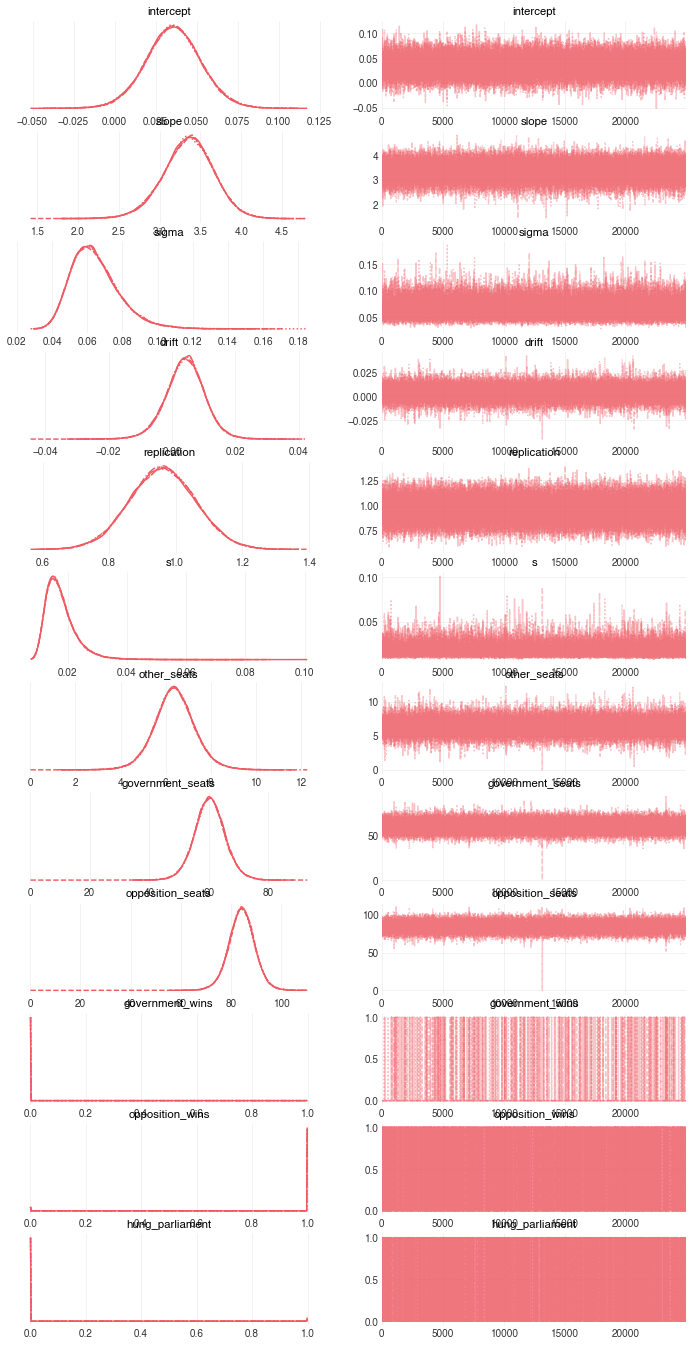

In [17]:
az.plot_trace(fit, var_names=['intercept', 'slope', 'sigma', # 
                              'drift', 'replication', 's',
                              'other_seats', 'government_seats',
                              'opposition_seats', 'government_wins',
                              'opposition_wins', 'hung_parliament'])

## Visualise results

In [18]:
results_df = fit.to_frame()

In [19]:
results_df.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'slope', 'intercept', 'sigma', 'drift',
       'replication', 's', 'seats_estimate.1', 'seats_estimate.2',
       'seats_estimate.3', 'seats_estimate.4', 'seats_estimate.5',
       'seats_estimate.6', 'seats_estimate.7', 'seats_estimate.8',
       'seats_estimate.9', 'seats_estimate.10', 'seats_estimate.11',
       'seats_estimate.12', 'seats_estimate.13', 'seats_estimate.14',
       'seats_estimate.15', 'seats_estimate.16', 'seats_estimate.17',
       'seats_estimate.18', 'seats_estimate.19', 'seats_estimate.20',
       'predict_interval.1', 'predict_interval.2', 'predict_interval.3',
       'predict_interval.4', 'predict_interval.5', 'predict_interval.6',
       'predict_interval.7', 'predict_interval.8', 'predict_interval.9',
       'predict_interval.10', 'predict_interval.11', 'predict_interval.12',
       'predict_interval.13', 'predict_interval.14', 'predict_interval.15'

In [20]:
def plot_finalise(ax, title=None, xlabel=None, ylabel=None, lfooter=None):
    
    # annotate the plot
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if lfooter is not None:
        ax.figure.text(0.005, 0.005, lfooter, 
                       ha='left', va='bottom',
                       c='#999999', style='italic', 
                       fontsize=10)
        
    ax.figure.tight_layout(pad=1.1)    
    
    ax.figure.savefig(CHART_DIR+title+'.png', dpi=300)
    
    # close
    plt.show()
    plt.close()

In [21]:
def plot_seats_won(party, title, colour):
    sw = results_df[party].round(0).value_counts()
    sw = sw.sort_index() / sw.sum()
    outright_win = sw[sw.index > WIN_THRESHOLD].sum() / sw.sum()
    lfooter = f'Outright win probability = {round(outright_win, 5)}'
    sw.index = sw.index.astype(int)
    _, ax = plt.subplots()
    ax.margins(0.02)
    ax.bar(x=sw.index, height=sw, color=colour)
    plot_finalise(ax, title,
                  xlabel='Number of seats won',
                  ylabel='Probability',
                 lfooter=lfooter)

### Seats won

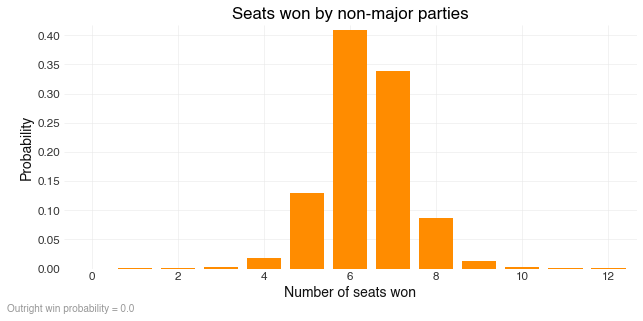

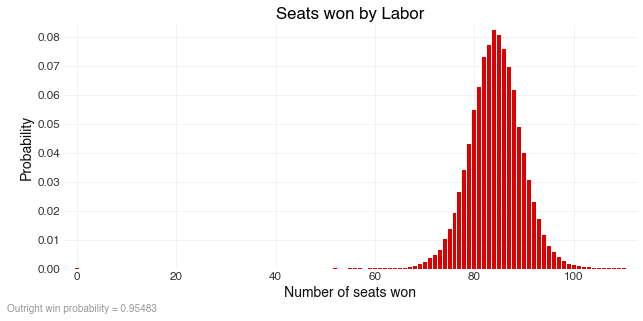

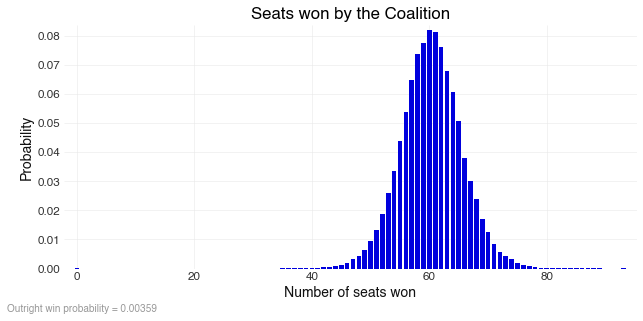

In [22]:
plot_seats_won('other_seats', 'Seats won by non-major parties', 'darkorange')
plot_seats_won('opposition_seats', 'Seats won by Labor', '#dd0000')
plot_seats_won('government_seats', 'Seats won by the Coalition', '#0000dd')

### House outcome

parameters
Labour Wins Outright       0.95484
Hung Parliament            0.04157
Coalition Wins Outright    0.00359
dtype: float64


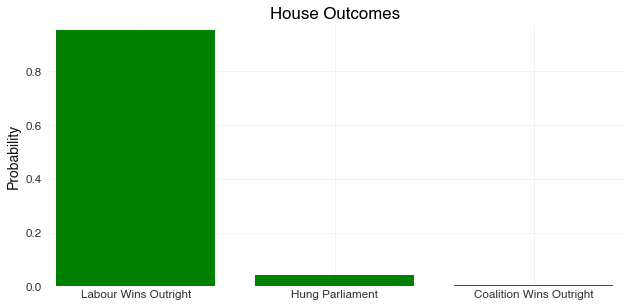

In [23]:
ho = results_df[['government_wins', 'opposition_wins', 'hung_parliament']].sum()
renamer = {
    'opposition_wins': 'Labour Wins Outright',
    'hung_parliament': 'Hung Parliament',
    'government_wins': 'Coalition Wins Outright',
}
ho = ho.rename(index=renamer)
order = list(renamer.values())
ho = (ho / ho.sum())[order]
print(ho)
_, ax = plt.subplots()
ax.margins(0.02)
ax.bar(x=ho.index, height=ho, color='green')
plot_finalise(ax, 'House Outcomes',
              xlabel=None,
              ylabel='Probability')

## Relationship between 2pp vote share majority party seat share

This looks at the linear regression between 2pp vote share for the government of the day (defined by party in governmnet on the day of the election) and the seats won as a proportion of all majority party seats wone. (We treat non-majority part seats differently).

In [24]:
quants = [0.005, 0.025, 0.100, 0.250, 0.500, 0.750, 0.900, 0.975, 0.995]
LOW = 'low'
HIGH = 'high'
ranges = pd.DataFrame({
    '99%': (0.005, 0.995),
    '95%': (0.025, 0.975),
    '80%': (0.100, 0.900),
    '50%': (0.250, 0.750),
}, index=[LOW, HIGH]).T
ranges

,low,high
99%,0.005,0.995
95%,0.025,0.975
80%,0.100,0.900
50%,0.250,0.750


In [25]:
def get_estimates_quants(pattern):

    # Get seat estimate quantiles
    seat_estimate = (
        results_df[results_df.columns[
            results_df.columns.str.contains(pattern)
        ]]
    )
    seat_estimate.columns = seat_history.index
    seat_estimate = seat_estimate.quantile(quants).T

    # link to votes
    seat_estimate['2pp votes'] = seat_history['Govt 2pp votes margin']
    seat_estimate = seat_estimate.sort_values('2pp votes')
    
    return seat_estimate
        
estimates = get_estimates_quants('seats_estimate')

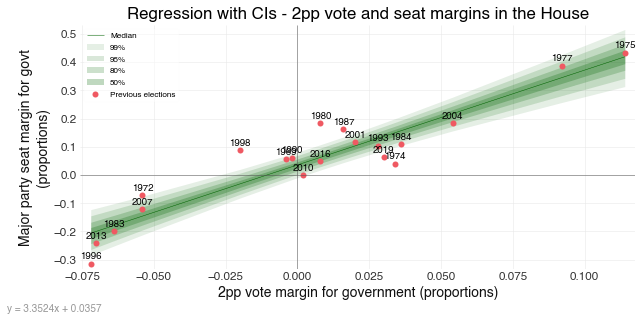

In [26]:
def plot_est_quants(estimates, title):
    # plot this relationship
    fig, ax = plt.subplots()
    ax.margins(0.02)
    alpha = 0.1
    for x, y in ranges.iterrows():
        low = y[0]
        high = y[1]
        lowpoint = estimates[low]
        highpoint = estimates[high]
        ax.fill_between(x=estimates['2pp votes'], y1=lowpoint, y2=highpoint,
                    color='darkgreen', alpha = alpha, label=x,)
        alpha += 0.05
    
    ax.plot(estimates['2pp votes'], estimates[0.500], 
        color='darkgreen', lw=0.5, label='Median')

    ax.scatter(seat_history['Govt 2pp votes margin'],
               seat_history['Govt seats margin'],
               label='Previous elections')

    ax.axhline(0, lw=0.5, color='#555555')
    ax.axvline(0, lw=0.5, color='#555555')

    for x, y, s in zip(seat_history['Govt 2pp votes margin'],
                       seat_history['Govt seats margin']+0.01,
                       seat_history.index.year.astype(str)):
        ax.text(x, y, s, fontsize='x-small', va='bottom', ha='center')
    

    lfooter = ( # key equation
        f"y = {results_df['slope'].mean().round(4)}x "
        f"+ {results_df['intercept'].mean().round(4)}"
    )

    ax.legend(loc='best')
    plot_finalise(ax, 
                  title=title,
                  xlabel='2pp vote margin for government (proportions)', 
                  ylabel='Major party seat margin for govt\n(proportions)',
                  lfooter=lfooter, )

plot_est_quants(estimates, 
                'Regression with CIs - 2pp vote and seat margins in the House')

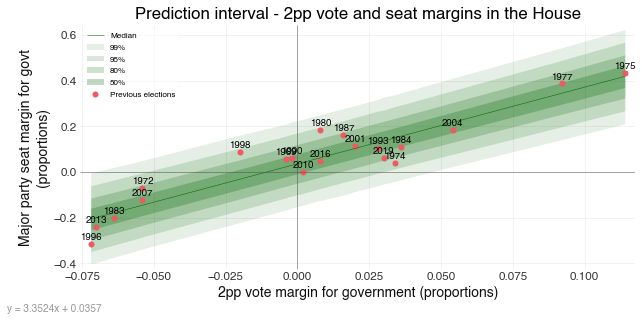

In [27]:
predictions = get_estimates_quants('predict_interval')
plot_est_quants(predictions, 
                'Prediction interval - 2pp vote and seat margins in the House')

## Model for non-major party members

Trend over recent years has been increasing representation, but overall, this year's numbers are much like last years. At hthe moment, this modelled with autoregressive(1) model.

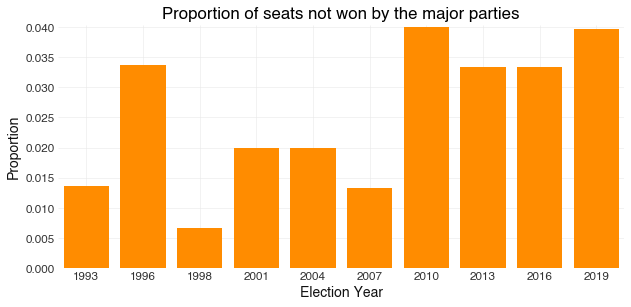

In [28]:
# Historical data as a bar chart
data = seat_history.loc[seat_history['Row number'] >= ar_from, 
                        'Proportion of others']
fig, ax = plt.subplots()
ax.margins(0.01)
ax.bar(x=[str(x) for x in data.index.year],
       height=data.values, color='darkorange')

plot_finalise(ax, 
              title='Proportion of seats not won by the major parties',
              xlabel='Election Year', 
              ylabel='Proportion',)
